In [1]:
import temporal_fusion_transformer as tft
import polars as pl
import matplotlib
import matplotlib.pyplot as plt
import matplotx
from absl_extra.logging_utils import setup_logging
from datetime import timedelta, datetime

matplotlib.style.use(matplotx.styles.dufte)
setup_logging(log_level="INFO")

In [2]:
electricity = tft.experiments.Electricity()
preprocessor = electricity.reload_preprocessor("../data/electricity/preprocessor.msgpack")
model = electricity.reload_model("../data/electricity/model.msgpack", return_attention=True)

In [3]:
# Filter out 1 entity and last 7 days (so plot if not too large)
mt_124_df = (
    pl.read_parquet("../data/electricity/test.parquet")
    .filter(pl.col("id") == "MT_124")
    .pipe(lambda df: df.with_columns(timestamp=pl.Series(preprocessor.restore_timestamps(df))))
    .filter(pl.col("timestamp") >= (pl.col("timestamp").max() - timedelta(days=8)))
)
mt_124_df

power_usage,year,month,hour,day,day_of_week,id,timestamp
f32,u16,u8,u8,u8,u8,str,datetime[μs]
389.952148,2014,8,0,31,7,"""MT_124""",2014-08-31 00:00:00
413.87561,2014,8,1,31,7,"""MT_124""",2014-08-31 01:00:00
357.655518,2014,8,2,31,7,"""MT_124""",2014-08-31 02:00:00
324.162689,2014,8,3,31,7,"""MT_124""",2014-08-31 03:00:00
272.727264,2014,8,4,31,7,"""MT_124""",2014-08-31 04:00:00
165.071777,2014,8,5,31,7,"""MT_124""",2014-08-31 05:00:00
144.736847,2014,8,6,31,7,"""MT_124""",2014-08-31 06:00:00
102.870811,2014,8,7,31,7,"""MT_124""",2014-08-31 07:00:00
163.875595,2014,8,8,31,7,"""MT_124""",2014-08-31 08:00:00


Applying preprocessor...:   0%|          | 0/7 [00:00<?, ?it/s]

Predicting...:   0%|          | 0/1 [00:00<?, ?it/s]

2023-10-03 15:08:22,886:[xla_bridge.py:603->backends()]:INFO: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-10-03 15:08:22,887:[xla_bridge.py:603->backends()]:INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-10-03 15:08:22,888:[xla_bridge.py:603->backends()]:INFO: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


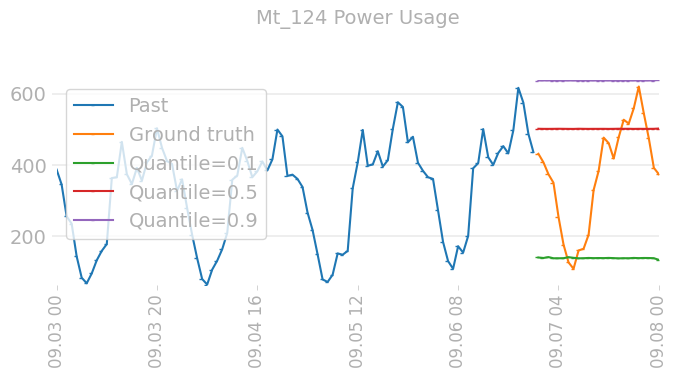

In [4]:
electricity.plot_predictions(
    df=mt_124_df.drop("timestamp"),
    preprocessor=preprocessor,
    model=model,
    entity="MT_124",
    truncate_past=datetime(2014, 9, 3),
)
plt.show()

Applying preprocessor...:   0%|          | 0/7 [00:00<?, ?it/s]

Predicting...:   0%|          | 0/1 [00:00<?, ?it/s]

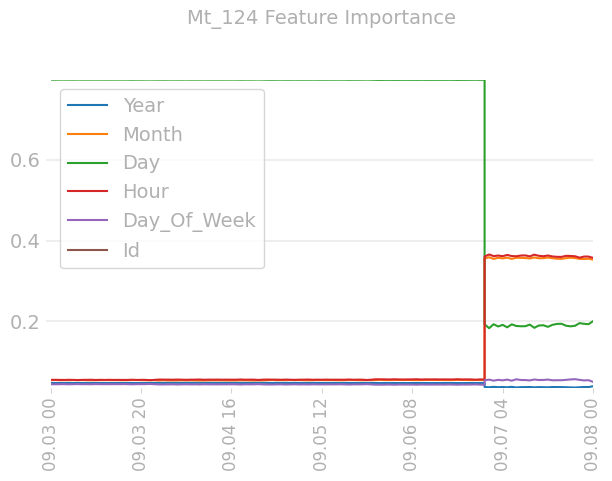

In [5]:
electricity.plot_feature_importance(
    df=mt_124_df.drop("timestamp"),
    preprocessor=preprocessor,
    model=model,
    entity="MT_124",
    truncate_past=datetime(2014, 9, 3),
)
plt.show()